In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    

In [6]:
import os
import keras
import gc
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import keras.backend as K

from data_generator.data_generator import COCODataLoader
from models.mobilenet_unet import MobilenetV2_base, relu6
from utils.losses import bce_dice_loss, iou_metric, iou_for_image, get_precision, get_multi_threshold_precision, focal_dice_loss, binary_focal_loss, dice_loss
from utils.utils import visualize

import skimage.io as io
import matplotlib.pyplot as plt

from utils.losses import iou_metric

In [8]:
mobilenet = MobilenetV2_base()
mobilenet.build_model(keras.layers.Input(shape=(401,401,3)))

mobilenet.model = keras.models.load_model('./checkpoints/mobilenet401-59_loss-0.6497_val_loss-0.4480.h5',
                                              custom_objects={'relu6' : relu6, 
                                                              'bce_dice_loss' : bce_dice_loss,
                                                              'iou_metric' : iou_metric,
                                                              'focal_dice_loss' : focal_dice_loss})


Building encoder...
Output stride: 16
Loading weights from /home/matsvei.rozanau/.keras/models/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5

Building decoder...
Block: 25
(?, 13, 13, 64) (?, 26, 26, 64)
Block: 28
(?, 26, 26, 64) (?, 51, 51, 32)
Block: 31
(?, 51, 51, 32) (?, 101, 101, 24)
Block: 33
(?, 101, 101, 24) (?, 201, 201, 16)
Block: 34
(?, 201, 201, 16) (?, 401, 401, 3)
Tensor("input_2:0", shape=(?, 401, 401, 3), dtype=float32) Tensor("segmentation_map/Sigmoid:0", shape=(?, 401, 401, 1), dtype=float32)


In [9]:
val_generator = COCODataLoader(
                    path_to_annotations='/home/matsvei.rozanau/hdd/datasets/coco_dataset/annotations/instances_val2017.json',
                    path_to_images='/home/matsvei.rozanau/hdd/datasets/coco_dataset/val2017/',
                    batch_size=32,
                    resize=(401,401),
                    augmentations=False, 
                    shuffle=False)


Loading COCO dataset from /home/matsvei.rozanau/hdd/datasets/coco_dataset/val2017/
loading annotations into memory...
Done (t=1.03s)
creating index...
index created!


In [14]:
images, masks = val_generator[6]

pred_mask = mobilenet.model.predict(images)
# pred_mask = tf.round(keras.backend.cast(pred_mask, dtype=tf.float64))
iou = keras.backend.get_value(iou_metric(y_true=masks, y_pred=pred_mask))
print(f"IoU: {iou[0]}")
masks = np.squeeze(masks)

IoU: 0.695999026298523


100%|██████████| 32/32 [01:32<00:00,  2.78s/it]


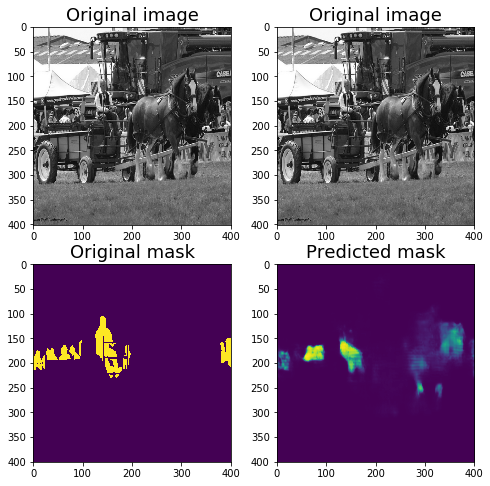

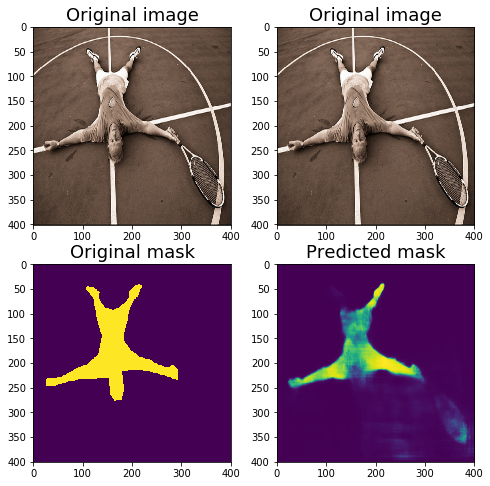

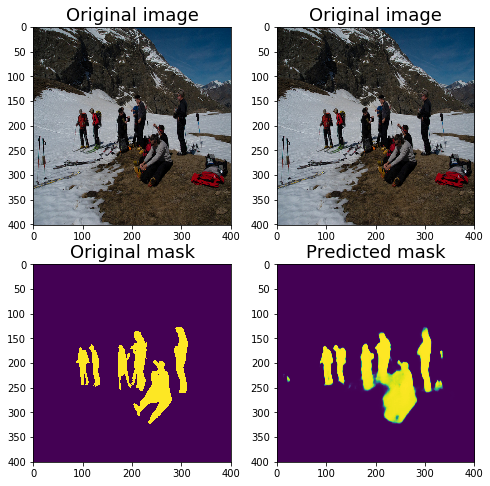

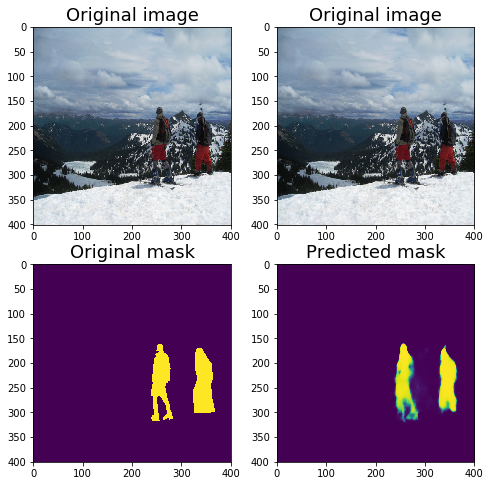

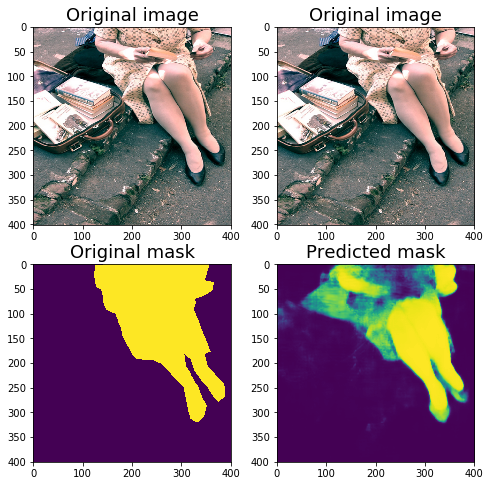

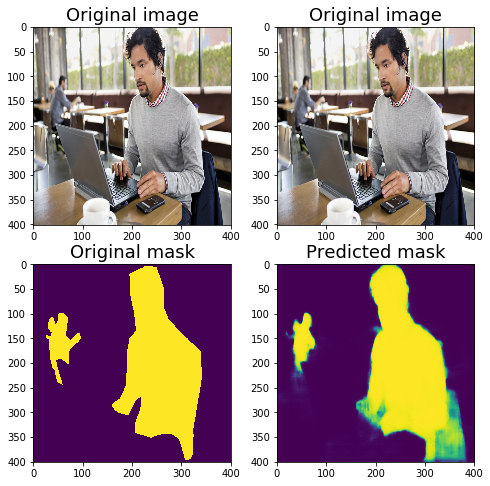

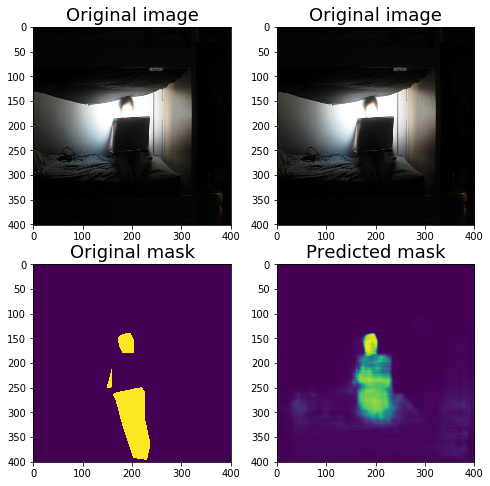

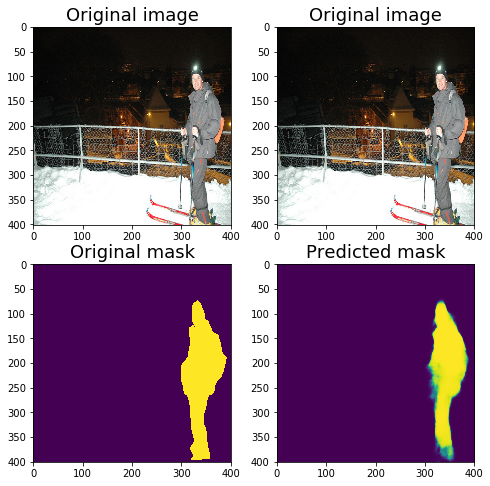

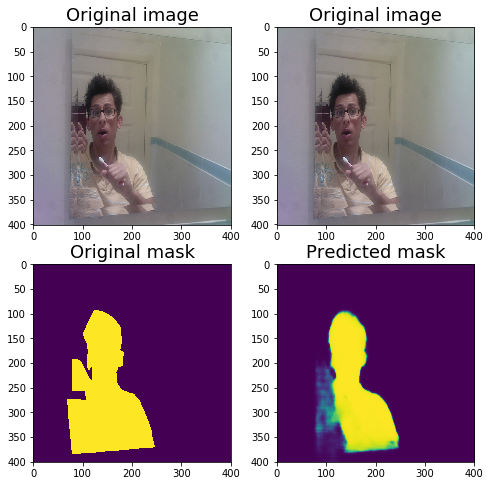

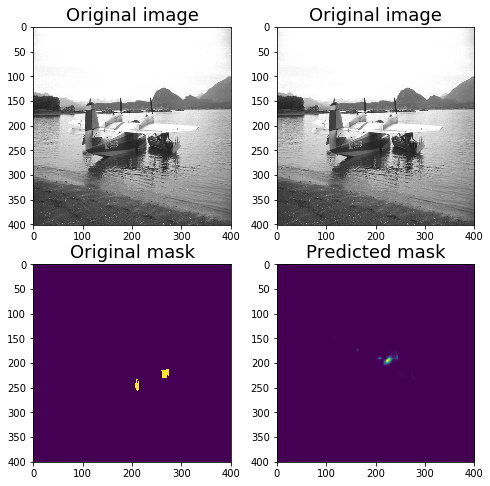

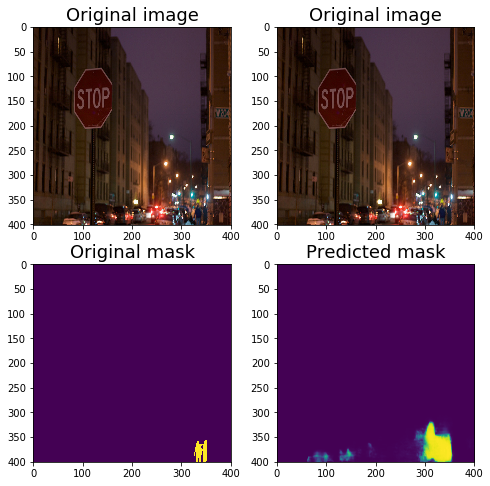

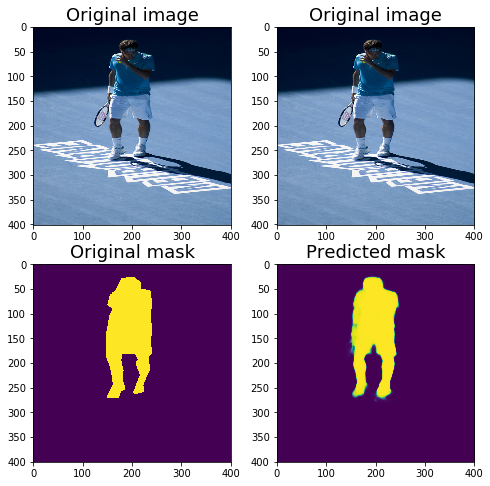

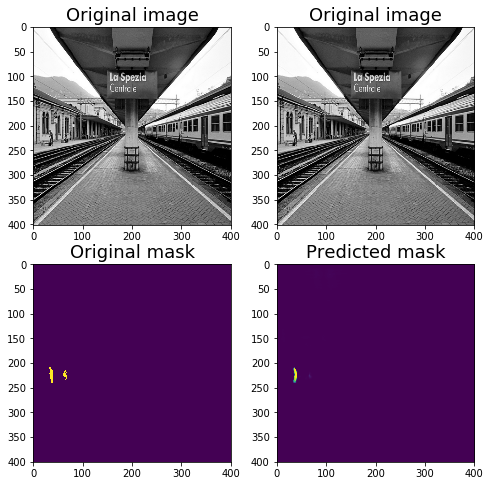

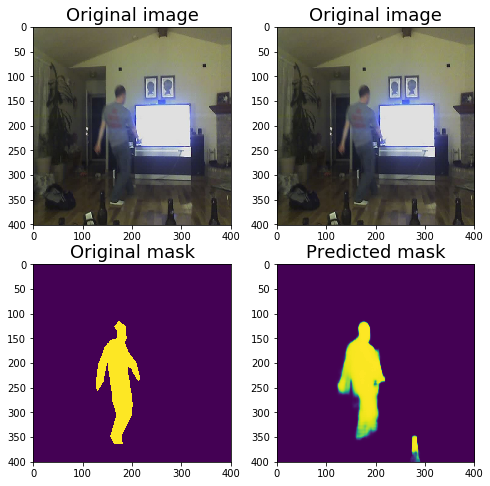

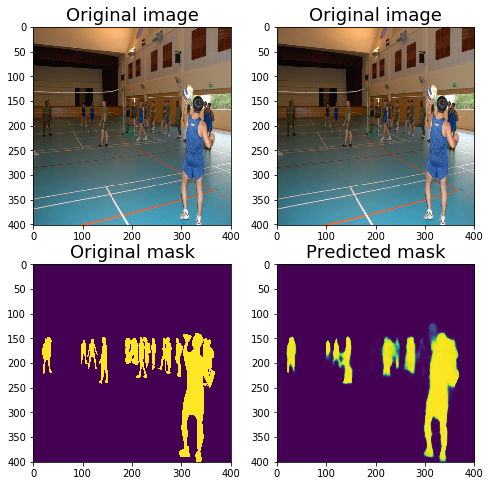

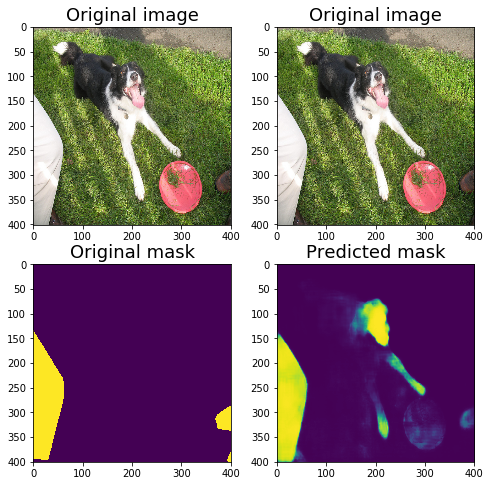

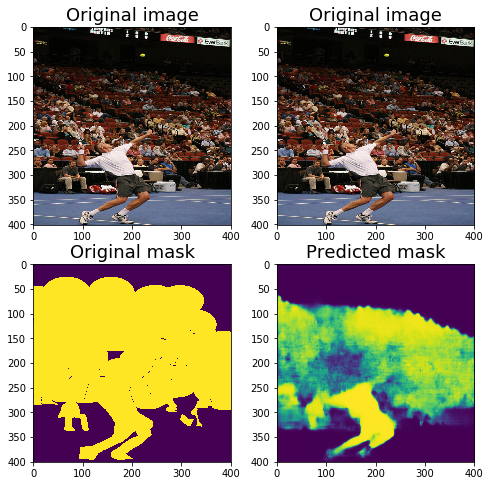

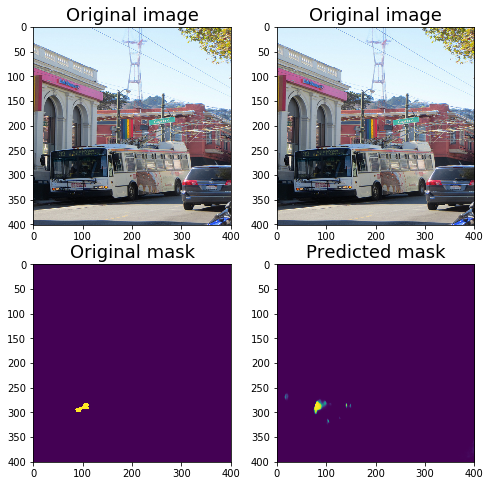

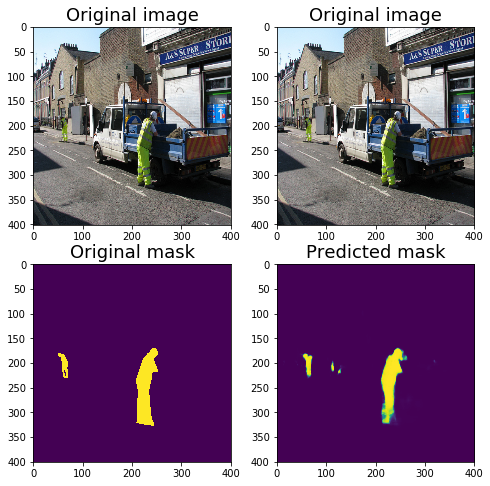

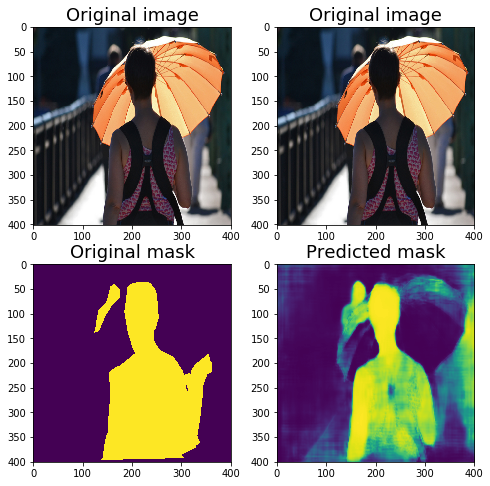

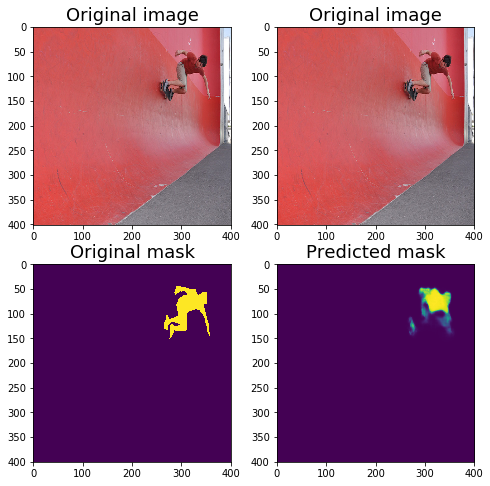

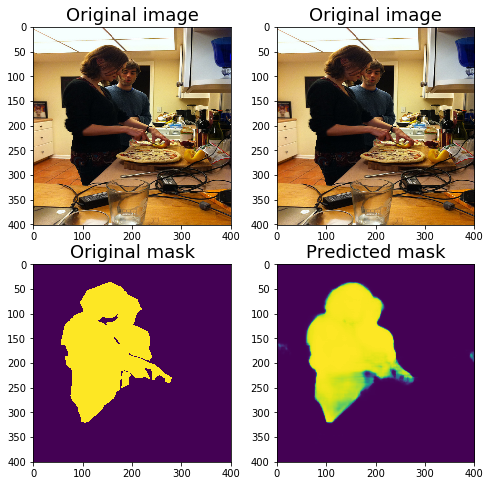

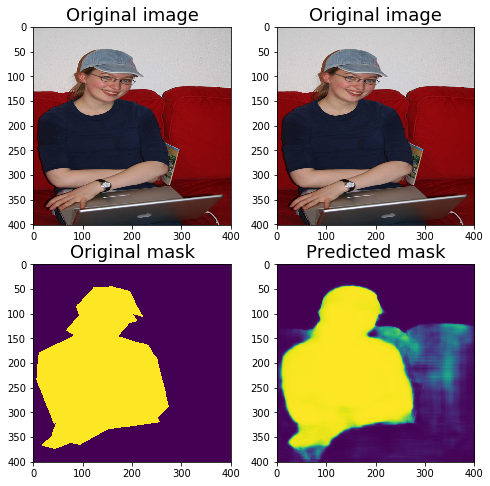

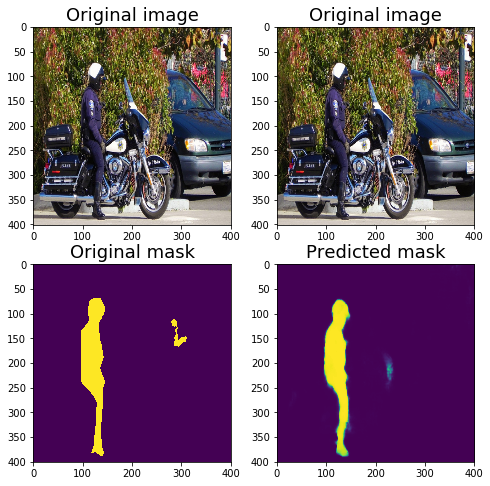

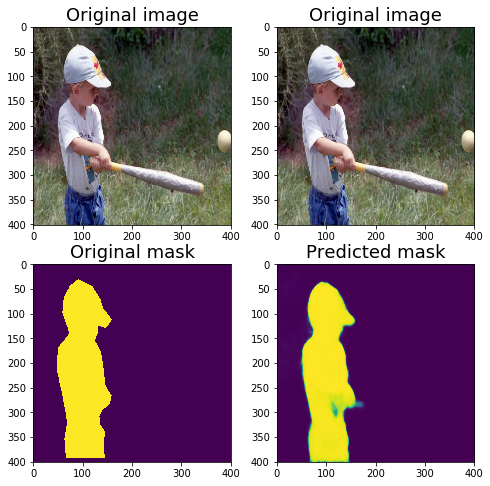

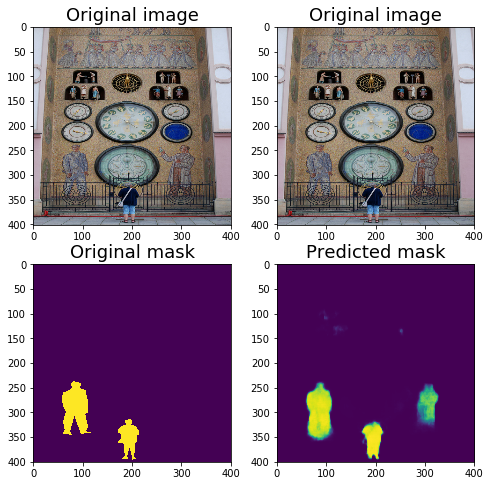

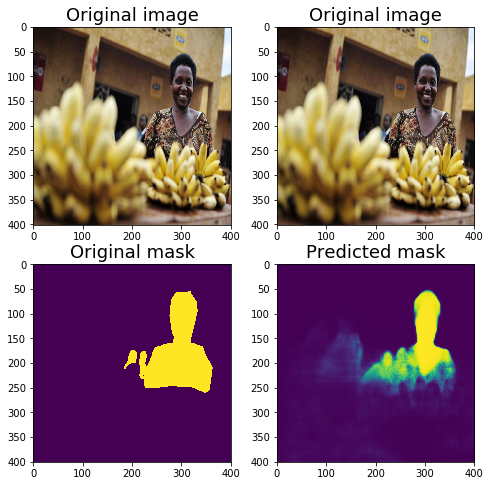

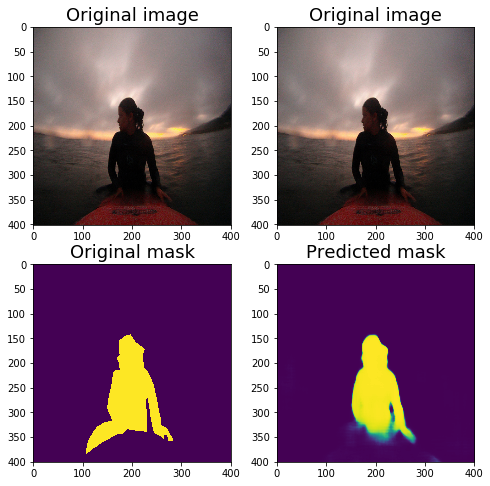

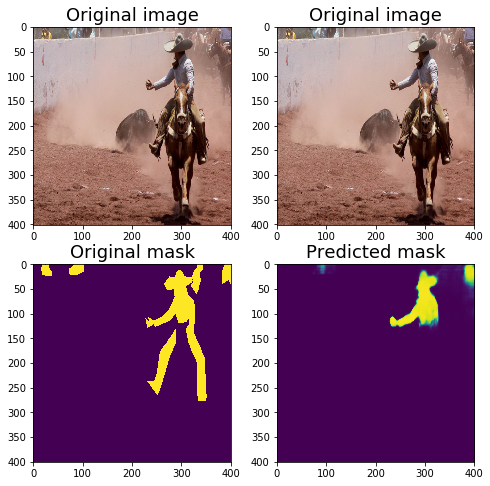

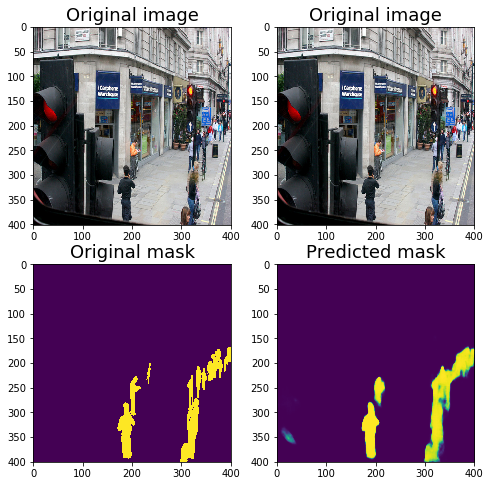

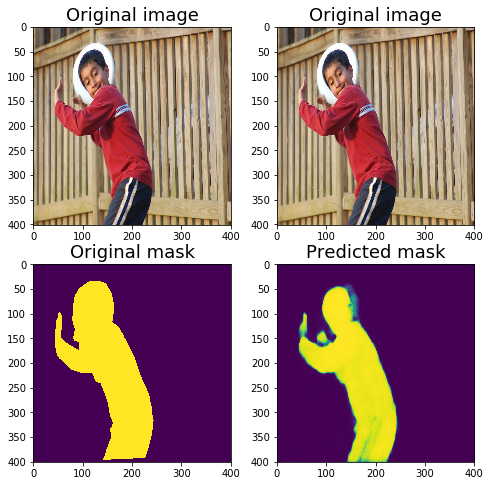

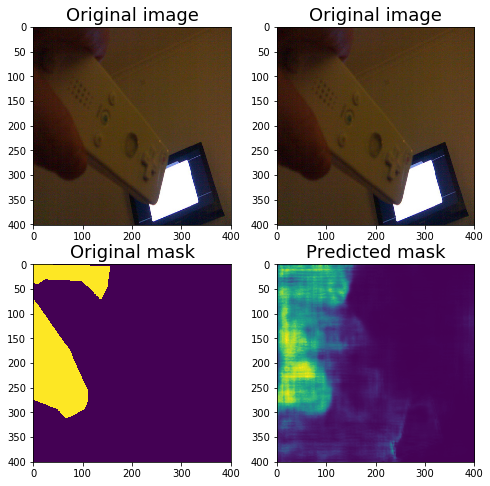

In [15]:
for i in tqdm(range(images.shape[0])):
    pred_mask = np.squeeze(mobilenet.model.predict(np.expand_dims(images[i], axis=0)))
    visualize(images[i], pred_mask, images[i], masks[i], name='./results/' + str(i) + '.png')

In [37]:
gt = np.array([
    [0,0,0,0,0],
    [0,1,1,1,0],
    [0,1,1,1,0],
    [0,1,1,1,0],
    [0,0,0,0,0]
])

pred = np.array([
    [0,0,0,0,0],
    [0,1,1,0,0],
    [0,1,1,1,0],
    [0,1,1,1,0],
    [0,0,0,0,0]
])

gt = tf.convert_to_tensor(gt, dtype=tf.float32)
pred = tf.convert_to_tensor(pred, dtype=tf.float32)

gt = K.expand_dims(K.expand_dims(gt, axis=0), axis=-1)
pred = K.expand_dims(K.expand_dims(pred, axis=0), axis=-1)

In [38]:
K.get_value(K.mean(K.binary_crossentropy(gt, pred)) - K.log(iou_metric(gt, pred)))

array([0.70188236], dtype=float32)

In [39]:
K.get_value(iou_metric(gt ,pred))

array([0.9444444], dtype=float32)

In [40]:
K.get_value(binary_focal_loss(gt ,pred))

4.029523